<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/tutorials/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
#!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
config_tickers

<module 'finrl.config_tickers' from '/home/k/anaconda3/envs/finRL/lib/python3.8/site-packages/finrl/config_tickers.py'>

In [5]:
print(config_tickers.ARK_TICKER)

['TSLA', 'ZM', 'ROKU', 'EXAS', 'NTLA', 'SQ', 'TDOC', 'CRSP', 'COIN', 'PATH', 'BEAM', 'TWLO', 'U', 'SHOP', 'DKNG', 'UW', 'RBLX', 'DNA', 'HOOD', 'PD', 'FATE', 'TWST', 'TXG', 'NVDA', 'VCYT', 'PACB', 'SGFY', 'TSP', 'SPOT', 'NVTA', 'MTLS', 'TWOU', 'CERS', 'BLI', 'GEN']


In [6]:
df = YahooDownloader(start_date = '2009-04-01',
                     end_date = '2022-09-11',
                     ticker_list = config_tickers.ARK_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-03-31,0.680,0.680,0.6300,0.680000,53200,CERS,1
1,2009-03-31,1.280,1.280,1.2300,1.250000,25500,EXAS,1
2,2009-03-31,14.680,15.110,14.6000,5.719993,12685100,GEN,1
3,2009-03-31,2.485,2.525,2.4475,2.262837,80527200,NVDA,1
4,2009-03-31,0.065,0.065,0.0650,0.065000,1100000,UW,1


In [9]:
df.tail()

,date,open,high,low,close,volume,tic,day
52937,2022-09-09,42.660000,44.580002,42.000000,44.040001,542900,TWST,4
52938,2022-09-09,34.630001,35.990002,34.169998,35.900002,754800,TXG,4
52939,2022-09-09,39.700001,41.430000,39.580002,41.299999,16513300,U,4
52940,2022-09-09,19.690001,19.959999,19.120001,19.950001,835800,VCYT,4
52941,2022-09-09,81.589996,83.699997,81.540001,82.620003,3964000,ZM,4


In [10]:
df.shape

(52942, 8)

In [11]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-03-31,0.680,0.680,0.6300,0.680000,53200,CERS,1
1,2009-03-31,1.280,1.280,1.2300,1.250000,25500,EXAS,1
2,2009-03-31,14.680,15.110,14.6000,5.719993,12685100,GEN,1
3,2009-03-31,2.485,2.525,2.4475,2.262837,80527200,NVDA,1
4,2009-03-31,0.065,0.065,0.0650,0.065000,1100000,UW,1


In [12]:
len(df.tic.unique())

35

In [13]:
df.tic.value_counts()

CERS    3386
GEN     3386
NVDA    3386
EXAS    3386
TSLA    3072
PACB    2988
FATE    2252
VCYT    2231
TWOU    2129
MTLS    2068
UW      1971
NVTA    1908
SHOP    1841
TDOC    1813
SQ      1713
NTLA    1598
TWLO    1565
CRSP    1483
ROKU    1246
SPOT    1119
TWST     971
PD       861
ZM       856
DKNG     789
TXG      755
BEAM     654
BLI      542
U        498
SGFY     398
RBLX     380
COIN     356
TSP      355
DNA      353
PATH     351
HOOD     282
Name: tic, dtype: int64

In [14]:
df

,date,open,high,low,close,volume,tic,day
0,2009-03-31,0.680000,0.680000,0.630000,0.680000,53200,CERS,1
1,2009-03-31,1.280000,1.280000,1.230000,1.250000,25500,EXAS,1
2,2009-03-31,14.680000,15.110000,14.600000,5.719993,12685100,GEN,1
3,2009-03-31,2.485000,2.525000,2.447500,2.262837,80527200,NVDA,1
4,2009-03-31,0.065000,0.065000,0.065000,0.065000,1100000,UW,1
...,...,...,...,...,...,...,...,...
52937,2022-09-09,42.660000,44.580002,42.000000,44.040001,542900,TWST,4
52938,2022-09-09,34.630001,35.990002,34.169998,35.900002,754800,TXG,4
52939,2022-09-09,39.700001,41.430000,39.580002,41.299999,16513300,U,4
52940,2022-09-09,19.690001,19.959999,19.120001,19.950001,835800,VCYT,4


In [15]:
def month_df(df):
    
    df['date'] = pd.to_datetime(df['date'])
    df['year-month'] = df['date'].map(lambda x: x.strftime('%Y-%m'))
    df = df.sort_values(['year-month', 'tic'], ascending=[True, True])
    dfo = df.groupby('year-month')['open']
    # df1['year'] = pd.DatetimeIndex(df1['date']).year
    # df1['month'] = pd.DatetimeIndex(df1['date']).month
    # df1.loc[df.groupby(["year","month"])["high"].idxmax()]
    return dfo

df1 = month_df(df)

df1

In [16]:
df

,date,open,high,low,close,volume,tic,day,year-month
0,2009-03-31,0.680000,0.680000,0.630000,0.680000,53200,CERS,1,2009-03
1,2009-03-31,1.280000,1.280000,1.230000,1.250000,25500,EXAS,1,2009-03
2,2009-03-31,14.680000,15.110000,14.600000,5.719993,12685100,GEN,1,2009-03
3,2009-03-31,2.485000,2.525000,2.447500,2.262837,80527200,NVDA,1,2009-03
4,2009-03-31,0.065000,0.065000,0.065000,0.065000,1100000,UW,1,2009-03
...,...,...,...,...,...,...,...,...,...
52937,2022-09-09,42.660000,44.580002,42.000000,44.040001,542900,TWST,4,2022-09
52938,2022-09-09,34.630001,35.990002,34.169998,35.900002,754800,TXG,4,2022-09
52939,2022-09-09,39.700001,41.430000,39.580002,41.299999,16513300,U,4,2022-09
52940,2022-09-09,19.690001,19.959999,19.120001,19.950001,835800,VCYT,4,2022-09


In [17]:
# import pandas as pd
# from stockstats import wrap
# df1 = df
# df = wrap(df1)
# df.init_all()
# df.columns

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [18]:
tech_indicators = ["macd","macds","macdh",
    "boll_ub","boll",
    "boll_lb",
    "rsi_13","rsi_21","rsi_34","rsi_55","rsi_89",
    "cci_30",
    "dx_30"]
# 'rsi_14', 'stochrsi','close_10_sma', 'close_50_sma','close_3_sma', 'close_5_sma', 'macd','atr_14'
                  
# 'change', 'rsi', 'rsi_14', 'stochrsi', 'rate', 'middle', 'tp', 'boll',
#                    'boll_ub', 'boll_lb', 'macd', 'macds', 'macdh', 'ppo', 'ppos', 'ppoh',
#                    'rsv_9', 'kdjk_9', 'kdjk', 'kdjd_9', 'kdjd', 'kdjj_9', 'kdjj', 'cr',
#                    'cr-ma1', 'cr-ma2', 'cr-ma3', 'cci', 'tr', 'atr', 'high_delta', 'um',
#                    'low_delta', 'dm', 'atr_14', 'pdi_14',
#                    'pdi', 'mdi_14', 'mdi', 'dx_14', 'dx',
#                    'adx', 'adxr', 'trix', 'tema', 'vr', 'close_10_sma', 'close_50_sma',
#                    'dma', 'vwma', 'chop', 'log-ret', 'mfi', 'wt1', 'wt2', 'wr',
#                    'supertrend_ub', 'supertrend_lb', 'supertrend'

In [19]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [20]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,year-month,macd,...,boll,boll_lb,rsi_13,rsi_21,rsi_34,rsi_55,rsi_89,cci_30,dx_30,turbulence
4698,2013-11-26,23.080000,23.260000,22.670000,8.865039,10093600,GEN,1,2013-11,-0.059021,...,8.98085,8.717010,40.478560,41.890024,43.513935,45.854051,48.466276,-35.734452,31.880109,6.522020
8945,2018-02-15,49.400002,49.580002,48.169998,49.139999,1921100,EXAS,3,2018-02,-1.097853,...,48.78550,45.229669,49.382984,47.765532,48.260500,49.963155,51.950813,-34.998437,32.554490,2.846607
11556,2020-09-21,6.240000,6.250000,6.090000,6.190000,1146400,CERS,0,2020-09,-0.119444,...,6.24100,5.787109,42.889527,44.541274,47.430815,49.831290,50.978113,-58.715904,1.921186,4.504176
12408,2021-07-27,4.790000,4.830000,4.670000,4.800000,1082600,CERS,1,2021-07,-0.208103,...,5.19150,4.469798,33.303149,36.702101,39.954425,42.802443,45.227172,-110.530993,34.810411,0.345333
9528,2018-09-14,7.350000,7.480000,7.240000,7.250000,704200,CERS,4,2018-09,0.021941,...,7.29600,6.750110,48.314580,50.485623,52.765882,54.890483,56.092493,28.388810,9.701664,1.416592


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [21]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 4, State Space: 61


In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [23]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2009-04-01'
train_end = '2020-04-01'
val_test_start = '2020-04-01'
val_test_end = '2022-09-11'

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [24]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 50_000, 
                 'ppo' : 50_000, 
                 'ddpg' : 50_000
                 }

In [25]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  37.923537735586116
======Model training from:  2009-04-01 to  2020-04-02T00:00:00.000000000
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_9
---------------------------------------
| time/                 |             |
|    fps                | 425         |
|    iterations         | 100         |
|    time_elapsed       | 1           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -5.84       |
|    explained_variance | 0           |
|    learning_rate      | 0.0005      |
|    n_updates          | 99          |
|    policy_loss        | -0.083      |
|    reward             | -0.00483914 |
|    std                | 1.04        |
|    value_loss         | 0.0179      |
---------------------------------------
--------------------------------------
| time/       

--------------------------------------
| time/                 |            |
|    fps                | 645        |
|    iterations         | 1400       |
|    time_elapsed       | 10         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -5.86      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 1399       |
|    policy_loss        | 6.01       |
|    reward             | -1.3367765 |
|    std                | 1.05       |
|    value_loss         | 8.67       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 646        |
|    iterations         | 1500       |
|    time_elapsed       | 11         |
|    total_timesteps    | 7500       |
| train/                |            |
|    entropy_loss       | -5.86      |
|    explained_variance | -1.19e-07  |
|    learning_rate      |

day: 2769, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 2942448.87
total_reward: 1942448.87
total_cost: 6096.13
total_trades: 6868
Sharpe: 0.502
--------------------------------------
| time/                 |            |
|    fps                | 658        |
|    iterations         | 2800       |
|    time_elapsed       | 21         |
|    total_timesteps    | 14000      |
| train/                |            |
|    entropy_loss       | -5.94      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 2799       |
|    policy_loss        | -0.674     |
|    reward             | 0.15726289 |
|    std                | 1.07       |
|    value_loss         | 0.0318     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 659         |
|    iterations         | 2900        |
|    time_elapsed       | 21          |
|    total_timeste

---------------------------------------
| time/                 |             |
|    fps                | 663         |
|    iterations         | 4100        |
|    time_elapsed       | 30          |
|    total_timesteps    | 20500       |
| train/                |             |
|    entropy_loss       | -6          |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.0005      |
|    n_updates          | 4099        |
|    policy_loss        | -10.3       |
|    reward             | -0.41164553 |
|    std                | 1.08        |
|    value_loss         | 3.22        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 663       |
|    iterations         | 4200      |
|    time_elapsed       | 31        |
|    total_timesteps    | 21000     |
| train/                |           |
|    entropy_loss       | -5.99     |
|    explained_variance | 0         |
|    learning_rate

-------------------------------------
| time/                 |           |
|    fps                | 661       |
|    iterations         | 5500      |
|    time_elapsed       | 41        |
|    total_timesteps    | 27500     |
| train/                |           |
|    entropy_loss       | -5.97     |
|    explained_variance | -0.000201 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5499      |
|    policy_loss        | 144       |
|    reward             | 27.283234 |
|    std                | 1.08      |
|    value_loss         | 564       |
-------------------------------------
day: 2769, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 7691772.44
total_reward: 6691772.44
total_cost: 7556.81
total_trades: 8822
Sharpe: 0.794
--------------------------------------
| time/                 |            |
|    fps                | 661        |
|    iterations         | 5600       |
|    time_elapsed       | 42         |
|    total_timesteps    | 28000      |

---------------------------------------
| time/                 |             |
|    fps                | 663         |
|    iterations         | 6800        |
|    time_elapsed       | 51          |
|    total_timesteps    | 34000       |
| train/                |             |
|    entropy_loss       | -6.03       |
|    explained_variance | 0           |
|    learning_rate      | 0.0005      |
|    n_updates          | 6799        |
|    policy_loss        | 16.7        |
|    reward             | -0.24802384 |
|    std                | 1.09        |
|    value_loss         | 5.58        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 663       |
|    iterations         | 6900      |
|    time_elapsed       | 52        |
|    total_timesteps    | 34500     |
| train/                |           |
|    entropy_loss       | -6.04     |
|    explained_variance | 0         |
|    learning_rate

-------------------------------------
| time/                 |           |
|    fps                | 665       |
|    iterations         | 8200      |
|    time_elapsed       | 61        |
|    total_timesteps    | 41000     |
| train/                |           |
|    entropy_loss       | -6.11     |
|    explained_variance | 0.0113    |
|    learning_rate      | 0.0005    |
|    n_updates          | 8199      |
|    policy_loss        | -113      |
|    reward             | -6.291779 |
|    std                | 1.12      |
|    value_loss         | 563       |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 665       |
|    iterations         | 8300      |
|    time_elapsed       | 62        |
|    total_timesteps    | 41500     |
| train/                |           |
|    entropy_loss       | -6.11     |
|    explained_variance | -0.00216  |
|    learning_rate      | 0.0005    |
|    n_updat

--------------------------------------
| time/                 |            |
|    fps                | 666        |
|    iterations         | 9500       |
|    time_elapsed       | 71         |
|    total_timesteps    | 47500      |
| train/                |            |
|    entropy_loss       | -6.16      |
|    explained_variance | 5.96e-08   |
|    learning_rate      | 0.0005     |
|    n_updates          | 9499       |
|    policy_loss        | -3.15      |
|    reward             | 0.81096214 |
|    std                | 1.13       |
|    value_loss         | 0.375      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 666        |
|    iterations         | 9600       |
|    time_elapsed       | 72         |
|    total_timesteps    | 48000      |
| train/                |            |
|    entropy_loss       | -6.18      |
|    explained_variance | 1.19e-07   |
|    learning_rate      |

------------------------------------------
| time/                   |              |
|    fps                  | 726          |
|    iterations           | 7            |
|    time_elapsed         | 19           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0056236703 |
|    clip_fraction        | 0.039        |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.7         |
|    explained_variance   | 0.0497       |
|    learning_rate        | 0.00025      |
|    loss                 | 24.1         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00371     |
|    reward               | -0.064113356 |
|    std                  | 1.01         |
|    value_loss           | 108          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 723         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 717          |
|    iterations           | 17           |
|    time_elapsed         | 48           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0018613231 |
|    clip_fraction        | 0.0304       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.78        |
|    explained_variance   | 0.185        |
|    learning_rate        | 0.00025      |
|    loss                 | 2.1          |
|    n_updates            | 160          |
|    policy_gradient_loss | 0.000979     |
|    reward               | 0.056877576  |
|    std                  | 1.03         |
|    value_loss           | 5.42         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 717          |
|    iterat

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 431       |
|    time_elapsed    | 25        |
|    total_timesteps | 11080     |
| train/             |           |
|    actor_loss      | -6.23e+03 |
|    critic_loss     | 1.16e+05  |
|    learning_rate   | 0.0005    |
|    n_updates       | 8310      |
|    reward          | 0.0       |
----------------------------------
day: 2769, episode: 45
begin_total_asset: 1000000.00
end_total_asset: 1000000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 393       |
|    time_elapsed    | 56        |
|    total_timesteps | 22160     |
| train/             |           |
|    actor_loss      | -6.73e+03 |
|    critic_loss     | 2.21e+04  |
|    learning_rate   | 0.0005    |
|    n_updates       | 19390     |
|    reward          | 0.0 

------------------------------------
| time/                 |          |
|    fps                | 672      |
|    iterations         | 1000     |
|    time_elapsed       | 7        |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -5.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 999      |
|    policy_loss        | 118      |
|    reward             | 8.017192 |
|    std                | 1.05     |
|    value_loss         | 556      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 672       |
|    iterations         | 1100      |
|    time_elapsed       | 8         |
|    total_timesteps    | 5500      |
| train/                |           |
|    entropy_loss       | -5.9      |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 10

--------------------------------------
| time/                 |            |
|    fps                | 672        |
|    iterations         | 2400       |
|    time_elapsed       | 17         |
|    total_timesteps    | 12000      |
| train/                |            |
|    entropy_loss       | -5.9       |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0005     |
|    n_updates          | 2399       |
|    policy_loss        | 2.92       |
|    reward             | 0.96410286 |
|    std                | 1.06       |
|    value_loss         | 1.31       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 672        |
|    iterations         | 2500       |
|    time_elapsed       | 18         |
|    total_timesteps    | 12500      |
| train/                |            |
|    entropy_loss       | -5.9       |
|    explained_variance | 1.19e-07   |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 672       |
|    iterations         | 3700      |
|    time_elapsed       | 27        |
|    total_timesteps    | 18500     |
| train/                |           |
|    entropy_loss       | -5.91     |
|    explained_variance | -0.0347   |
|    learning_rate      | 0.0005    |
|    n_updates          | 3699      |
|    policy_loss        | -12.2     |
|    reward             | 1.1324364 |
|    std                | 1.06      |
|    value_loss         | 8.7       |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 672       |
|    iterations         | 3800      |
|    time_elapsed       | 28        |
|    total_timesteps    | 19000     |
| train/                |           |
|    entropy_loss       | -5.9      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updat

------------------------------------------
| time/                 |                |
|    fps                | 668            |
|    iterations         | 5100           |
|    time_elapsed       | 38             |
|    total_timesteps    | 25500          |
| train/                |                |
|    entropy_loss       | -5.95          |
|    explained_variance | 0              |
|    learning_rate      | 0.0005         |
|    n_updates          | 5099           |
|    policy_loss        | 62.1           |
|    reward             | -0.00094520603 |
|    std                | 1.07           |
|    value_loss         | 450            |
------------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 668        |
|    iterations         | 5200       |
|    time_elapsed       | 38         |
|    total_timesteps    | 26000      |
| train/                |            |
|    entropy_loss       | -5.96      |


------------------------------------
| time/                 |          |
|    fps                | 666      |
|    iterations         | 6400     |
|    time_elapsed       | 47       |
|    total_timesteps    | 32000    |
| train/                |          |
|    entropy_loss       | -6.01    |
|    explained_variance | -0.293   |
|    learning_rate      | 0.0005   |
|    n_updates          | 6399     |
|    policy_loss        | 3.5      |
|    reward             | 1.859326 |
|    std                | 1.09     |
|    value_loss         | 0.466    |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 666       |
|    iterations         | 6500      |
|    time_elapsed       | 48        |
|    total_timesteps    | 32500     |
| train/                |           |
|    entropy_loss       | -6.04     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 64

--------------------------------------
| time/                 |            |
|    fps                | 666        |
|    iterations         | 7800       |
|    time_elapsed       | 58         |
|    total_timesteps    | 39000      |
| train/                |            |
|    entropy_loss       | -6.02      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0005     |
|    n_updates          | 7799       |
|    policy_loss        | 33.5       |
|    reward             | -15.696077 |
|    std                | 1.09       |
|    value_loss         | 79.5       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 666       |
|    iterations         | 7900      |
|    time_elapsed       | 59        |
|    total_timesteps    | 39500     |
| train/                |           |
|    entropy_loss       | -6.02     |
|    explained_variance | -0.000549 |
|    learning_rate      | 0.0005  

--------------------------------------
| time/                 |            |
|    fps                | 667        |
|    iterations         | 9100       |
|    time_elapsed       | 68         |
|    total_timesteps    | 45500      |
| train/                |            |
|    entropy_loss       | -6.01      |
|    explained_variance | 1.79e-07   |
|    learning_rate      | 0.0005     |
|    n_updates          | 9099       |
|    policy_loss        | -0.774     |
|    reward             | 0.18291982 |
|    std                | 1.09       |
|    value_loss         | 0.0337     |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 667          |
|    iterations         | 9200         |
|    time_elapsed       | 68           |
|    total_timesteps    | 46000        |
| train/                |              |
|    entropy_loss       | -6.02        |
|    explained_variance | 0.00511      |
|    le

------------------------------------------
| time/                   |              |
|    fps                  | 737          |
|    iterations           | 4            |
|    time_elapsed         | 11           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0050235493 |
|    clip_fraction        | 0.0572       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.71        |
|    explained_variance   | 0.00163      |
|    learning_rate        | 0.00025      |
|    loss                 | 11.1         |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00275     |
|    reward               | -1.8647324   |
|    std                  | 1.01         |
|    value_loss           | 17.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 728         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 711          |
|    iterations           | 14           |
|    time_elapsed         | 40           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0045108367 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.85        |
|    explained_variance   | -0.00222     |
|    learning_rate        | 0.00025      |
|    loss                 | 41.4         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00356     |
|    reward               | 0.0485441    |
|    std                  | 1.05         |
|    value_loss           | 92           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 711         |
|    iteration

day: 2832, episode: 35
begin_total_asset: 1000000.00
end_total_asset: 5297553.89
total_reward: 4297553.89
total_cost: 11121.62
total_trades: 11086
Sharpe: 0.605
-----------------------------------------
| time/                   |             |
|    fps                  | 708         |
|    iterations           | 24          |
|    time_elapsed         | 69          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.005370701 |
|    clip_fraction        | 0.0243      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.88       |
|    explained_variance   | 0.0174      |
|    learning_rate        | 0.00025     |
|    loss                 | 80.4        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00455    |
|    reward               | -0.44145674 |
|    std                  | 1.05        |
|    value_loss           | 274         |
-----------------------------------------

--------------------------------------
| time/                 |            |
|    fps                | 639        |
|    iterations         | 600        |
|    time_elapsed       | 4          |
|    total_timesteps    | 3000       |
| train/                |            |
|    entropy_loss       | -5.87      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0005     |
|    n_updates          | 599        |
|    policy_loss        | 0.245      |
|    reward             | 0.11714132 |
|    std                | 1.05       |
|    value_loss         | 0.0115     |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 640       |
|    iterations         | 700       |
|    time_elapsed       | 5         |
|    total_timesteps    | 3500      |
| train/                |           |
|    entropy_loss       | -5.87     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005  

----------------------------------------
| time/                 |              |
|    fps                | 636          |
|    iterations         | 2000         |
|    time_elapsed       | 15           |
|    total_timesteps    | 10000        |
| train/                |              |
|    entropy_loss       | -5.86        |
|    explained_variance | -0.0416      |
|    learning_rate      | 0.0005       |
|    n_updates          | 1999         |
|    policy_loss        | 13.3         |
|    reward             | -0.043633636 |
|    std                | 1.05         |
|    value_loss         | 5.48         |
----------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 636      |
|    iterations         | 2100     |
|    time_elapsed       | 16       |
|    total_timesteps    | 10500    |
| train/                |          |
|    entropy_loss       | -5.87    |
|    explained_variance | 0        |
|    learni

--------------------------------------
| time/                 |            |
|    fps                | 633        |
|    iterations         | 3300       |
|    time_elapsed       | 26         |
|    total_timesteps    | 16500      |
| train/                |            |
|    entropy_loss       | -5.88      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 3299       |
|    policy_loss        | -10.4      |
|    reward             | -4.7968297 |
|    std                | 1.05       |
|    value_loss         | 5.58       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 634       |
|    iterations         | 3400      |
|    time_elapsed       | 26        |
|    total_timesteps    | 17000     |
| train/                |           |
|    entropy_loss       | -5.88     |
|    explained_variance | -0.096    |
|    learning_rate      | 0.0005  

-------------------------------------
| time/                 |           |
|    fps                | 633       |
|    iterations         | 4700      |
|    time_elapsed       | 37        |
|    total_timesteps    | 23500     |
| train/                |           |
|    entropy_loss       | -5.91     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 4699      |
|    policy_loss        | 0.478     |
|    reward             | -0.248466 |
|    std                | 1.06      |
|    value_loss         | 0.178     |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 633        |
|    iterations         | 4800       |
|    time_elapsed       | 37         |
|    total_timesteps    | 24000      |
| train/                |            |
|    entropy_loss       | -5.92      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
| 

--------------------------------------
| time/                 |            |
|    fps                | 633        |
|    iterations         | 6000       |
|    time_elapsed       | 47         |
|    total_timesteps    | 30000      |
| train/                |            |
|    entropy_loss       | -5.96      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0005     |
|    n_updates          | 5999       |
|    policy_loss        | -0.356     |
|    reward             | -1.2752297 |
|    std                | 1.07       |
|    value_loss         | 0.453      |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 633       |
|    iterations         | 6100      |
|    time_elapsed       | 48        |
|    total_timesteps    | 30500     |
| train/                |           |
|    entropy_loss       | -5.95     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0005  

-------------------------------------
| time/                 |           |
|    fps                | 633       |
|    iterations         | 7400      |
|    time_elapsed       | 58        |
|    total_timesteps    | 37000     |
| train/                |           |
|    entropy_loss       | -5.95     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 7399      |
|    policy_loss        | -25.8     |
|    reward             | 2.5105357 |
|    std                | 1.07      |
|    value_loss         | 21.8      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 633        |
|    iterations         | 7500       |
|    time_elapsed       | 59         |
|    total_timesteps    | 37500      |
| train/                |            |
|    entropy_loss       | -5.95      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 636       |
|    iterations         | 8800      |
|    time_elapsed       | 69        |
|    total_timesteps    | 44000     |
| train/                |           |
|    entropy_loss       | -5.98     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 8799      |
|    policy_loss        | 1.35      |
|    reward             | 0.6897981 |
|    std                | 1.08      |
|    value_loss         | 0.469     |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 636       |
|    iterations         | 8900      |
|    time_elapsed       | 69        |
|    total_timesteps    | 44500     |
| train/                |           |
|    entropy_loss       | -5.98     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updat

-----------------------------------
| time/              |            |
|    fps             | 844        |
|    iterations      | 1          |
|    time_elapsed    | 2          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.01698091 |
-----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 762          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0041791555 |
|    clip_fraction        | 0.0215       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.66        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0519       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.

-----------------------------------------
| time/                   |             |
|    fps                  | 703         |
|    iterations           | 11          |
|    time_elapsed         | 32          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.006237277 |
|    clip_fraction        | 0.0618      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.65       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 13.7        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00341    |
|    reward               | -6.4498773  |
|    std                  | 0.995       |
|    value_loss           | 29.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 700          |
|    iterations           | 12 

------------------------------------------
| time/                   |              |
|    fps                  | 692          |
|    iterations           | 21           |
|    time_elapsed         | 62           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0050648423 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | 0.19         |
|    learning_rate        | 0.00025      |
|    loss                 | 258          |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00512     |
|    reward               | 11.986766    |
|    std                  | 1            |
|    value_loss           | 277          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 692          |
|    iterat

--------------------------------------
| time/                 |            |
|    fps                | 628        |
|    iterations         | 200        |
|    time_elapsed       | 1          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -5.86      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0005     |
|    n_updates          | 199        |
|    policy_loss        | -0.168     |
|    reward             | 0.04430235 |
|    std                | 1.05       |
|    value_loss         | 0.00117    |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 633        |
|    iterations         | 300        |
|    time_elapsed       | 2          |
|    total_timesteps    | 1500       |
| train/                |            |
|    entropy_loss       | -5.89      |
|    explained_variance | 1.19e-07   |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 649       |
|    iterations         | 1600      |
|    time_elapsed       | 12        |
|    total_timesteps    | 8000      |
| train/                |           |
|    entropy_loss       | -5.94     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 1599      |
|    policy_loss        | -30.1     |
|    reward             | 7.9791155 |
|    std                | 1.07      |
|    value_loss         | 72.8      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 650        |
|    iterations         | 1700       |
|    time_elapsed       | 13         |
|    total_timesteps    | 8500       |
| train/                |            |
|    entropy_loss       | -5.94      |
|    explained_variance | 0.00989    |
|    learning_rate      | 0.0005     |
| 

day: 2958, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 22572078.29
total_reward: 21572078.29
total_cost: 11659.47
total_trades: 8896
Sharpe: 0.948
--------------------------------------
| time/                 |            |
|    fps                | 657        |
|    iterations         | 3000       |
|    time_elapsed       | 22         |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -5.98      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 2999       |
|    policy_loss        | -2.67      |
|    reward             | -0.2078431 |
|    std                | 1.08       |
|    value_loss         | 0.217      |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 657         |
|    iterations         | 3100        |
|    time_elapsed       | 23          |
|    total_time

---------------------------------------
| time/                 |             |
|    fps                | 657         |
|    iterations         | 4300        |
|    time_elapsed       | 32          |
|    total_timesteps    | 21500       |
| train/                |             |
|    entropy_loss       | -6.04       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0005      |
|    n_updates          | 4299        |
|    policy_loss        | -3.65       |
|    reward             | -0.83013326 |
|    std                | 1.1         |
|    value_loss         | 0.713       |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 657         |
|    iterations         | 4400        |
|    time_elapsed       | 33          |
|    total_timesteps    | 22000       |
| train/                |             |
|    entropy_loss       | -6.06       |
|    explained_variance | 0           |


--------------------------------------
| time/                 |            |
|    fps                | 656        |
|    iterations         | 5700       |
|    time_elapsed       | 43         |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -6.11      |
|    explained_variance | -0.00117   |
|    learning_rate      | 0.0005     |
|    n_updates          | 5699       |
|    policy_loss        | -86.9      |
|    reward             | -0.5981443 |
|    std                | 1.12       |
|    value_loss         | 260        |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 656       |
|    iterations         | 5800      |
|    time_elapsed       | 44        |
|    total_timesteps    | 29000     |
| train/                |           |
|    entropy_loss       | -6.1      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005  

-------------------------------------
| time/                 |           |
|    fps                | 656       |
|    iterations         | 7000      |
|    time_elapsed       | 53        |
|    total_timesteps    | 35000     |
| train/                |           |
|    entropy_loss       | -6.2      |
|    explained_variance | 0.000703  |
|    learning_rate      | 0.0005    |
|    n_updates          | 6999      |
|    policy_loss        | -77.8     |
|    reward             | 29.770988 |
|    std                | 1.14      |
|    value_loss         | 301       |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 656       |
|    iterations         | 7100      |
|    time_elapsed       | 54        |
|    total_timesteps    | 35500     |
| train/                |           |
|    entropy_loss       | -6.21     |
|    explained_variance | 0.000574  |
|    learning_rate      | 0.0005    |
|    n_updat

----------------------------------------
| time/                 |              |
|    fps                | 656          |
|    iterations         | 8400         |
|    time_elapsed       | 64           |
|    total_timesteps    | 42000        |
| train/                |              |
|    entropy_loss       | -6.35        |
|    explained_variance | 0            |
|    learning_rate      | 0.0005       |
|    n_updates          | 8399         |
|    policy_loss        | 0.0715       |
|    reward             | -0.009133769 |
|    std                | 1.18         |
|    value_loss         | 0.000175     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 656          |
|    iterations         | 8500         |
|    time_elapsed       | 64           |
|    total_timesteps    | 42500        |
| train/                |              |
|    entropy_loss       | -6.41        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 655        |
|    iterations         | 9700       |
|    time_elapsed       | 73         |
|    total_timesteps    | 48500      |
| train/                |            |
|    entropy_loss       | -6.61      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 9699       |
|    policy_loss        | -45.1      |
|    reward             | 0.13036774 |
|    std                | 1.26       |
|    value_loss         | 61.6       |
--------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 655      |
|    iterations         | 9800     |
|    time_elapsed       | 74       |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -6.62    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n

------------------------------------------
| time/                   |              |
|    fps                  | 704          |
|    iterations           | 8            |
|    time_elapsed         | 23           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0051628742 |
|    clip_fraction        | 0.0494       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.7         |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0333       |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00315     |
|    reward               | -0.020140007 |
|    std                  | 1.01         |
|    value_loss           | 0.198        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 702          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 695          |
|    iterations           | 18           |
|    time_elapsed         | 53           |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0039750454 |
|    clip_fraction        | 0.0182       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.67        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.00025      |
|    loss                 | 6.47         |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.0003      |
|    reward               | 0.90967435   |
|    std                  | 0.997        |
|    value_loss           | 15.3         |
------------------------------------------
day: 2958, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 6475417.59
total_reward: 5475417.59
total_cost: 12490.73
total_trades:

day: 2958, episode: 45
begin_total_asset: 1000000.00
end_total_asset: 1000000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| time/              |           |
|    episodes        | 12        |
|    fps             | 375       |
|    time_elapsed    | 94        |
|    total_timesteps | 35508     |
| train/             |           |
|    actor_loss      | -2.13e+03 |
|    critic_loss     | 2.1e+03   |
|    learning_rate   | 0.0005    |
|    n_updates       | 32549     |
|    reward          | 0.0       |
----------------------------------
day: 2958, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 1000000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| time/              |           |
|    episodes        | 16        |
|    fps             | 370       |
|    time_elapsed    | 127       |
|    total_timesteps | 47344     |
| train/             |           |
|    actor_loss      | -1.13e+03 |

--------------------------------------
| time/                 |            |
|    fps                | 658        |
|    iterations         | 1200       |
|    time_elapsed       | 9          |
|    total_timesteps    | 6000       |
| train/                |            |
|    entropy_loss       | -6.05      |
|    explained_variance | -0.00385   |
|    learning_rate      | 0.0005     |
|    n_updates          | 1199       |
|    policy_loss        | 52.9       |
|    reward             | -14.813981 |
|    std                | 1.1        |
|    value_loss         | 212        |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 658        |
|    iterations         | 1300       |
|    time_elapsed       | 9          |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -6.07      |
|    explained_variance | 5.96e-08   |
|    learning_rate      |

--------------------------------------
| time/                 |            |
|    fps                | 654        |
|    iterations         | 2600       |
|    time_elapsed       | 19         |
|    total_timesteps    | 13000      |
| train/                |            |
|    entropy_loss       | -6.17      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 2599       |
|    policy_loss        | -0.0138    |
|    reward             | 0.04500803 |
|    std                | 1.13       |
|    value_loss         | 0.933      |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 653       |
|    iterations         | 2700      |
|    time_elapsed       | 20        |
|    total_timesteps    | 13500     |
| train/                |           |
|    entropy_loss       | -6.18     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005  

-------------------------------------
| time/                 |           |
|    fps                | 652       |
|    iterations         | 4000      |
|    time_elapsed       | 30        |
|    total_timesteps    | 20000     |
| train/                |           |
|    entropy_loss       | -6.2      |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 3999      |
|    policy_loss        | -131      |
|    reward             | -5.719744 |
|    std                | 1.14      |
|    value_loss         | 408       |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 652       |
|    iterations         | 4100      |
|    time_elapsed       | 31        |
|    total_timesteps    | 20500     |
| train/                |           |
|    entropy_loss       | -6.19     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 652       |
|    iterations         | 5400      |
|    time_elapsed       | 41        |
|    total_timesteps    | 27000     |
| train/                |           |
|    entropy_loss       | -6.22     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5399      |
|    policy_loss        | -278      |
|    reward             | 47.61912  |
|    std                | 1.15      |
|    value_loss         | 3.83e+03  |
-------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 652           |
|    iterations         | 5500          |
|    time_elapsed       | 42            |
|    total_timesteps    | 27500         |
| train/                |               |
|    entropy_loss       | -6.24         |
|    explained_variance | 0             |
|    learning_

--------------------------------------
| time/                 |            |
|    fps                | 653        |
|    iterations         | 6700       |
|    time_elapsed       | 51         |
|    total_timesteps    | 33500      |
| train/                |            |
|    entropy_loss       | -6.27      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 6699       |
|    policy_loss        | 1.88       |
|    reward             | 0.08450062 |
|    std                | 1.16       |
|    value_loss         | 0.134      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 651        |
|    iterations         | 6800       |
|    time_elapsed       | 52         |
|    total_timesteps    | 34000      |
| train/                |            |
|    entropy_loss       | -6.26      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 653         |
|    iterations         | 8100        |
|    time_elapsed       | 61          |
|    total_timesteps    | 40500       |
| train/                |             |
|    entropy_loss       | -6.21       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0005      |
|    n_updates          | 8099        |
|    policy_loss        | 12.8        |
|    reward             | -0.63376516 |
|    std                | 1.14        |
|    value_loss         | 11.1        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 653        |
|    iterations         | 8200       |
|    time_elapsed       | 62         |
|    total_timesteps    | 41000      |
| train/                |            |
|    entropy_loss       | -6.22      |
|    explained_variance | 0          |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 654         |
|    iterations         | 9400        |
|    time_elapsed       | 71          |
|    total_timesteps    | 47000       |
| train/                |             |
|    entropy_loss       | -6.25       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0005      |
|    n_updates          | 9399        |
|    policy_loss        | 13.7        |
|    reward             | -0.04251607 |
|    std                | 1.16        |
|    value_loss         | 6.94        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 654       |
|    iterations         | 9500      |
|    time_elapsed       | 72        |
|    total_timesteps    | 47500     |
| train/                |           |
|    entropy_loss       | -6.24     |
|    explained_variance | -1.19e-07 |
|    learning_rate

------------------------------------------
| time/                   |              |
|    fps                  | 709          |
|    iterations           | 6            |
|    time_elapsed         | 17           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0051730126 |
|    clip_fraction        | 0.0395       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.7         |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0763       |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00253     |
|    reward               | -0.013781292 |
|    std                  | 1            |
|    value_loss           | 0.234        |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 705        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 16          |
|    time_elapsed         | 47          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.004970884 |
|    clip_fraction        | 0.0471      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.74       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 26          |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00226    |
|    reward               | 1.9680628   |
|    std                  | 1.02        |
|    value_loss           | 43.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 695          |
|    iterations           | 17 

======PPO Validation from:  2021-04-05T00:00:00.000000000 to  2021-07-02T00:00:00.000000000
PPO Sharpe Ratio:  0.515511027390828
======DDPG Training========
{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cuda device
Logging to tensorboard_log/ddpg/ddpg_378_8
day: 3021, episode: 35
begin_total_asset: 1000000.00
end_total_asset: 1479989.48
total_reward: 479989.48
total_cost: 1342.68
total_trades: 4400
Sharpe: 0.267
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 417      |
|    time_elapsed    | 28       |
|    total_timesteps | 12088    |
| train/             |          |
|    actor_loss      | -267     |
|    critic_loss     | 9.89e+03 |
|    learning_rate   | 0.0005   |
|    n_updates       | 9066     |
|    reward          | 8.962396 |
---------------------------------
day: 3021, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 14284240.82
total_reward: 13284240.82
total_co

---------------------------------------
| time/                 |             |
|    fps                | 657         |
|    iterations         | 900         |
|    time_elapsed       | 6           |
|    total_timesteps    | 4500        |
| train/                |             |
|    entropy_loss       | -5.86       |
|    explained_variance | 0           |
|    learning_rate      | 0.0005      |
|    n_updates          | 899         |
|    policy_loss        | -5.73       |
|    reward             | -0.15589567 |
|    std                | 1.05        |
|    value_loss         | 1.22        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 657       |
|    iterations         | 1000      |
|    time_elapsed       | 7         |
|    total_timesteps    | 5000      |
| train/                |           |
|    entropy_loss       | -5.85     |
|    explained_variance | 0.111     |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 657      |
|    iterations         | 2300     |
|    time_elapsed       | 17       |
|    total_timesteps    | 11500    |
| train/                |          |
|    entropy_loss       | -5.92    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2299     |
|    policy_loss        | -103     |
|    reward             | 7.767521 |
|    std                | 1.06     |
|    value_loss         | 276      |
------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 657        |
|    iterations         | 2400       |
|    time_elapsed       | 18         |
|    total_timesteps    | 12000      |
| train/                |            |
|    entropy_loss       | -5.91      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0005     |
|    n_updates    

--------------------------------------
| time/                 |            |
|    fps                | 656        |
|    iterations         | 3600       |
|    time_elapsed       | 27         |
|    total_timesteps    | 18000      |
| train/                |            |
|    entropy_loss       | -5.93      |
|    explained_variance | 0.00828    |
|    learning_rate      | 0.0005     |
|    n_updates          | 3599       |
|    policy_loss        | 172        |
|    reward             | -15.948229 |
|    std                | 1.07       |
|    value_loss         | 1.05e+03   |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 656        |
|    iterations         | 3700       |
|    time_elapsed       | 28         |
|    total_timesteps    | 18500      |
| train/                |            |
|    entropy_loss       | -5.92      |
|    explained_variance | 0.00262    |
|    learning_rate      |

--------------------------------------
| time/                 |            |
|    fps                | 656        |
|    iterations         | 5000       |
|    time_elapsed       | 38         |
|    total_timesteps    | 25000      |
| train/                |            |
|    entropy_loss       | -5.94      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 4999       |
|    policy_loss        | -12.6      |
|    reward             | -0.7738252 |
|    std                | 1.07       |
|    value_loss         | 3.43       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 655       |
|    iterations         | 5100      |
|    time_elapsed       | 38        |
|    total_timesteps    | 25500     |
| train/                |           |
|    entropy_loss       | -5.96     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005  

-------------------------------------
| time/                 |           |
|    fps                | 654       |
|    iterations         | 6300      |
|    time_elapsed       | 48        |
|    total_timesteps    | 31500     |
| train/                |           |
|    entropy_loss       | -5.99     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 6299      |
|    policy_loss        | -5.28     |
|    reward             | 0.8710738 |
|    std                | 1.08      |
|    value_loss         | 1.3       |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 654       |
|    iterations         | 6400      |
|    time_elapsed       | 48        |
|    total_timesteps    | 32000     |
| train/                |           |
|    entropy_loss       | -5.99     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updat

---------------------------------------
| time/                 |             |
|    fps                | 653         |
|    iterations         | 7700        |
|    time_elapsed       | 58          |
|    total_timesteps    | 38500       |
| train/                |             |
|    entropy_loss       | -6.08       |
|    explained_variance | 0           |
|    learning_rate      | 0.0005      |
|    n_updates          | 7699        |
|    policy_loss        | -19         |
|    reward             | -0.67727447 |
|    std                | 1.11        |
|    value_loss         | 10.4        |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 653          |
|    iterations         | 7800         |
|    time_elapsed       | 59           |
|    total_timesteps    | 39000        |
| train/                |              |
|    entropy_loss       | -6.1         |
|    explained_variance | 5.96e-

-------------------------------------
| time/                 |           |
|    fps                | 653       |
|    iterations         | 9100      |
|    time_elapsed       | 69        |
|    total_timesteps    | 45500     |
| train/                |           |
|    entropy_loss       | -6.18     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 9099      |
|    policy_loss        | 9.26      |
|    reward             | 8.413777  |
|    std                | 1.13      |
|    value_loss         | 8.41      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 653      |
|    iterations         | 9200     |
|    time_elapsed       | 70       |
|    total_timesteps    | 46000    |
| train/                |          |
|    entropy_loss       | -6.2     |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates        

------------------------------------------
| time/                   |              |
|    fps                  | 719          |
|    iterations           | 4            |
|    time_elapsed         | 11           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0062978375 |
|    clip_fraction        | 0.057        |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.7         |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.00025      |
|    loss                 | 8.33         |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00433     |
|    reward               | 0.021740511  |
|    std                  | 1.01         |
|    value_loss           | 23.9         |
------------------------------------------
day: 3084, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1637179.49
total_reward: 637179.49
total_cost: 14569.92
total_trades: 

-----------------------------------------
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 14          |
|    time_elapsed         | 41          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.00542498  |
|    clip_fraction        | 0.0659      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.77       |
|    explained_variance   | -0.0315     |
|    learning_rate        | 0.00025     |
|    loss                 | 18.7        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00581    |
|    reward               | -0.21285687 |
|    std                  | 1.03        |
|    value_loss           | 57.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 694          |
|    iterations           | 15 

-----------------------------------------
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 24          |
|    time_elapsed         | 71          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.003486319 |
|    clip_fraction        | 0.017       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.83       |
|    explained_variance   | 0.00291     |
|    learning_rate        | 0.00025     |
|    loss                 | 380         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00294    |
|    reward               | -5.4875717  |
|    std                  | 1.04        |
|    value_loss           | 875         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 25    

---------------------------------------
| time/                 |             |
|    fps                | 629         |
|    iterations         | 700         |
|    time_elapsed       | 5           |
|    total_timesteps    | 3500        |
| train/                |             |
|    entropy_loss       | -5.8        |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0005      |
|    n_updates          | 699         |
|    policy_loss        | 1.09        |
|    reward             | -0.12385675 |
|    std                | 1.03        |
|    value_loss         | 0.0756      |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 630       |
|    iterations         | 800       |
|    time_elapsed       | 6         |
|    total_timesteps    | 4000      |
| train/                |           |
|    entropy_loss       | -5.81     |
|    explained_variance | 0         |
|    learning_rate

---------------------------------------
| time/                 |             |
|    fps                | 642         |
|    iterations         | 2100        |
|    time_elapsed       | 16          |
|    total_timesteps    | 10500       |
| train/                |             |
|    entropy_loss       | -5.93       |
|    explained_variance | 0           |
|    learning_rate      | 0.0005      |
|    n_updates          | 2099        |
|    policy_loss        | -5.5        |
|    reward             | 0.012671707 |
|    std                | 1.07        |
|    value_loss         | 1.43        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 642        |
|    iterations         | 2200       |
|    time_elapsed       | 17         |
|    total_timesteps    | 11000      |
| train/                |            |
|    entropy_loss       | -5.94      |
|    explained_variance | -1.19e-07  |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 644         |
|    iterations         | 3400        |
|    time_elapsed       | 26          |
|    total_timesteps    | 17000       |
| train/                |             |
|    entropy_loss       | -6.01       |
|    explained_variance | 0           |
|    learning_rate      | 0.0005      |
|    n_updates          | 3399        |
|    policy_loss        | -0.00537    |
|    reward             | 0.070552155 |
|    std                | 1.09        |
|    value_loss         | 1.49        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 644        |
|    iterations         | 3500       |
|    time_elapsed       | 27         |
|    total_timesteps    | 17500      |
| train/                |            |
|    entropy_loss       | -6.02      |
|    explained_variance | 0          |
|    lear

-------------------------------------
| time/                 |           |
|    fps                | 646       |
|    iterations         | 4800      |
|    time_elapsed       | 37        |
|    total_timesteps    | 24000     |
| train/                |           |
|    entropy_loss       | -6.27     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4799      |
|    policy_loss        | 0.0759    |
|    reward             | 5.5765996 |
|    std                | 1.16      |
|    value_loss         | 26.9      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 646        |
|    iterations         | 4900       |
|    time_elapsed       | 37         |
|    total_timesteps    | 24500      |
| train/                |            |
|    entropy_loss       | -6.28      |
|    explained_variance | 1.79e-07   |
|    learning_rate      | 0.0005     |
| 

--------------------------------------
| time/                 |            |
|    fps                | 645        |
|    iterations         | 6200       |
|    time_elapsed       | 47         |
|    total_timesteps    | 31000      |
| train/                |            |
|    entropy_loss       | -6.32      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 6199       |
|    policy_loss        | 99.6       |
|    reward             | -21.879496 |
|    std                | 1.18       |
|    value_loss         | 511        |
--------------------------------------
day: 3147, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 21316948.99
total_reward: 20316948.99
total_cost: 19100.68
total_trades: 9921
Sharpe: 0.988
--------------------------------------
| time/                 |            |
|    fps                | 645        |
|    iterations         | 6300       |
|    time_elapsed       | 48         |
|    total_timestep

--------------------------------------
| time/                 |            |
|    fps                | 644        |
|    iterations         | 7500       |
|    time_elapsed       | 58         |
|    total_timesteps    | 37500      |
| train/                |            |
|    entropy_loss       | -6.33      |
|    explained_variance | 0.00484    |
|    learning_rate      | 0.0005     |
|    n_updates          | 7499       |
|    policy_loss        | -62.4      |
|    reward             | -25.582937 |
|    std                | 1.18       |
|    value_loss         | 532        |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 644         |
|    iterations         | 7600        |
|    time_elapsed       | 58          |
|    total_timesteps    | 38000       |
| train/                |             |
|    entropy_loss       | -6.35       |
|    explained_variance | 5.96e-08    |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 644          |
|    iterations         | 8900         |
|    time_elapsed       | 69           |
|    total_timesteps    | 44500        |
| train/                |              |
|    entropy_loss       | -6.42        |
|    explained_variance | 0            |
|    learning_rate      | 0.0005       |
|    n_updates          | 8899         |
|    policy_loss        | 4.2          |
|    reward             | 0.0067296997 |
|    std                | 1.21         |
|    value_loss         | 0.577        |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 644         |
|    iterations         | 9000        |
|    time_elapsed       | 69          |
|    total_timesteps    | 45000       |
| train/                |             |
|    entropy_loss       | -6.43       |
|    explained_variance 

-----------------------------------------
| time/                   |             |
|    fps                  | 758         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006704339 |
|    clip_fraction        | 0.0831      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.68       |
|    explained_variance   | -0.00706    |
|    learning_rate        | 0.00025     |
|    loss                 | 0.268       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00423    |
|    reward               | 0.20810717  |
|    std                  | 1           |
|    value_loss           | 0.722       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 732          |
|    iterations           | 3  

------------------------------------------
| time/                   |              |
|    fps                  | 694          |
|    iterations           | 12           |
|    time_elapsed         | 35           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0053137643 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.76        |
|    explained_variance   | 0.0173       |
|    learning_rate        | 0.00025      |
|    loss                 | 294          |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00555     |
|    reward               | -0.21845542  |
|    std                  | 1.02         |
|    value_loss           | 354          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 693         |
|    iteration

day: 3147, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2365348.57
total_reward: 1365348.57
total_cost: 16105.32
total_trades: 11947
Sharpe: 0.434
------------------------------------------
| time/                   |              |
|    fps                  | 688          |
|    iterations           | 22           |
|    time_elapsed         | 65           |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0061406945 |
|    clip_fraction        | 0.0772       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.78        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | 1.78         |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00174     |
|    reward               | 0.037003245  |
|    std                  | 1.03         |
|    value_loss           | 4.07         |
----------------------

-------------------------------------
| time/                 |           |
|    fps                | 649       |
|    iterations         | 400       |
|    time_elapsed       | 3         |
|    total_timesteps    | 2000      |
| train/                |           |
|    entropy_loss       | -5.85     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 399       |
|    policy_loss        | -29.5     |
|    reward             | 4.1971974 |
|    std                | 1.04      |
|    value_loss         | 35.9      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 649       |
|    iterations         | 500       |
|    time_elapsed       | 3         |
|    total_timesteps    | 2500      |
| train/                |           |
|    entropy_loss       | -5.86     |
|    explained_variance | -0.00312  |
|    learning_rate      | 0.0005    |
|    n_updat

------------------------------------
| time/                 |          |
|    fps                | 651      |
|    iterations         | 1800     |
|    time_elapsed       | 13       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -5.89    |
|    explained_variance | 0.0127   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1799     |
|    policy_loss        | 30.8     |
|    reward             | 11.92487 |
|    std                | 1.05     |
|    value_loss         | 124      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 1900      |
|    time_elapsed       | 14        |
|    total_timesteps    | 9500      |
| train/                |           |
|    entropy_loss       | -5.9      |
|    explained_variance | 0.00295   |
|    learning_rate      | 0.0005    |
|    n_updates          | 18

------------------------------------
| time/                 |          |
|    fps                | 651      |
|    iterations         | 3200     |
|    time_elapsed       | 24       |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -5.94    |
|    explained_variance | -0.00126 |
|    learning_rate      | 0.0005   |
|    n_updates          | 3199     |
|    policy_loss        | 78.8     |
|    reward             | 35.80926 |
|    std                | 1.07     |
|    value_loss         | 2.26e+03 |
------------------------------------
day: 3210, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 36604451.39
total_reward: 35604451.39
total_cost: 18512.98
total_trades: 11974
Sharpe: 0.992
-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 3300      |
|    time_elapsed       | 25        |
|    total_timesteps    | 16500     |
| train/          

-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 4600      |
|    time_elapsed       | 35        |
|    total_timesteps    | 23000     |
| train/                |           |
|    entropy_loss       | -6.02     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 4599      |
|    policy_loss        | 5.1       |
|    reward             | 1.2069042 |
|    std                | 1.09      |
|    value_loss         | 2.09      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 4700      |
|    time_elapsed       | 36        |
|    total_timesteps    | 23500     |
| train/                |           |
|    entropy_loss       | -6.01     |
|    explained_variance | 0.0299    |
|    learning_rate      | 0.0005    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 6000      |
|    time_elapsed       | 46        |
|    total_timesteps    | 30000     |
| train/                |           |
|    entropy_loss       | -6.1      |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 5999      |
|    policy_loss        | -9.17     |
|    reward             | -6.570679 |
|    std                | 1.11      |
|    value_loss         | 15.4      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 6100      |
|    time_elapsed       | 46        |
|    total_timesteps    | 30500     |
| train/                |           |
|    entropy_loss       | -6.1      |
|    explained_variance | -0.00664  |
|    learning_rate      | 0.0005    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 7300      |
|    time_elapsed       | 56        |
|    total_timesteps    | 36500     |
| train/                |           |
|    entropy_loss       | -6.1      |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 7299      |
|    policy_loss        | 26.4      |
|    reward             | 2.7742927 |
|    std                | 1.11      |
|    value_loss         | 38.9      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 7400      |
|    time_elapsed       | 56        |
|    total_timesteps    | 37000     |
| train/                |           |
|    entropy_loss       | -6.09     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0005    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 8700      |
|    time_elapsed       | 66        |
|    total_timesteps    | 43500     |
| train/                |           |
|    entropy_loss       | -6.11     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 8699      |
|    policy_loss        | 6.77      |
|    reward             | 0.5077308 |
|    std                | 1.12      |
|    value_loss         | 4.99      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 8800      |
|    time_elapsed       | 67        |
|    total_timesteps    | 44000     |
| train/                |           |
|    entropy_loss       | -6.1      |
|    explained_variance | -0.0133   |
|    learning_rate      | 0.0005    |
|    n_updat

======A2C Validation from:  2021-12-31T00:00:00.000000000 to  2022-04-01T00:00:00.000000000
A2C Sharpe Ratio:  -0.04997450835411111
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Logging to tensorboard_log/ppo/ppo_567_5
------------------------------------
| time/              |             |
|    fps             | 831         |
|    iterations      | 1           |
|    time_elapsed    | 2           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.25519603 |
------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 750           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.0024073985  |
|    clip_fractio

-------------------------------------------
| time/                   |               |
|    fps                  | 693           |
|    iterations           | 11            |
|    time_elapsed         | 32            |
|    total_timesteps      | 22528         |
| train/                  |               |
|    approx_kl            | 0.0042572953  |
|    clip_fraction        | 0.0171        |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.7          |
|    explained_variance   | 0.149         |
|    learning_rate        | 0.00025       |
|    loss                 | 46.1          |
|    n_updates            | 100           |
|    policy_gradient_loss | -0.00566      |
|    reward               | -0.0012421912 |
|    std                  | 1.01          |
|    value_loss           | 272           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 692   

-----------------------------------------
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 21          |
|    time_elapsed         | 62          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.005820766 |
|    clip_fraction        | 0.0524      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.67       |
|    explained_variance   | 0.233       |
|    learning_rate        | 0.00025     |
|    loss                 | 141         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00423    |
|    reward               | -1.6514119  |
|    std                  | 0.998       |
|    value_loss           | 122         |
-----------------------------------------
day: 3210, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 13571438.16
total_reward: 12571438.16
total_cost: 15498.83
total_trades: 11895
Sharpe: 0.8

In [26]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2020-04-02,2020-07-02,PPO,0.158899,0.318541,0.0
1,189,2020-07-02,2020-10-01,PPO,0.116941,0.152668,-0.267598
2,252,2020-10-01,2020-12-31,A2C,0.128159,0.119817,0.102233
3,315,2020-12-31,2021-04-05,A2C,0.038973,0.021581,0.0
4,378,2021-04-05,2021-07-02,PPO,0.399388,0.515511,0.098758
5,441,2021-07-02,2021-10-01,DDPG,-0.218317,-0.362267,-0.141015
6,504,2021-10-01,2021-12-31,A2C,0.175185,-0.163485,0.0
7,567,2021-12-31,2022-04-01,PPO,-0.049975,0.032056,-0.242383


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [27]:
unique_trade_date = processed[(processed.date > val_test_start)&(processed.date <= val_test_end)].date.unique()

In [28]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.15668713878488635


In [29]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2020-07-02,NaN,2020-07-02
1,1.000005e+06,2020-07-06,0.000005,2020-07-06
2,1.000023e+06,2020-07-07,0.000018,2020-07-07
3,1.001093e+06,2020-07-08,0.001071,2020-07-08
4,1.001209e+06,2020-07-09,0.000115,2020-07-09


<AxesSubplot:>

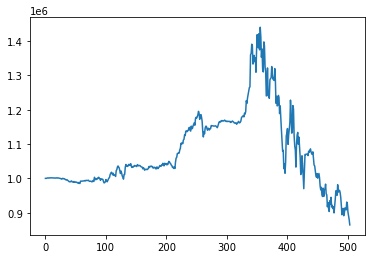

In [30]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [31]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.070267
Cumulative returns    -0.135596
Annual volatility      0.256730
Sharpe ratio          -0.156687
Calmar ratio          -0.175760
Stability              0.063913
Max drawdown          -0.399789
Omega ratio            0.965215
Sortino ratio         -0.226552
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.855817
Daily value at risk   -0.032505
dtype: float64


In [32]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (504, 8)
Annual return          0.093554
Cumulative returns     0.195860
Annual volatility      0.157482
Sharpe ratio           0.647896
Calmar ratio           0.498165
Stability              0.541829
Max drawdown          -0.187797
Omega ratio            1.114785
Sortino ratio          0.901417
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.910244
Daily value at risk   -0.019436
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

In [33]:
df_account_value

,account_value,date,daily_return,datadate
0,1.000000e+06,2020-07-02,NaN,2020-07-02
1,1.000005e+06,2020-07-06,0.000005,2020-07-06
2,1.000023e+06,2020-07-07,0.000018,2020-07-07
3,1.001093e+06,2020-07-08,0.001071,2020-07-08
4,1.001209e+06,2020-07-09,0.000115,2020-07-09
...,...,...,...,...
499,9.242817e+05,2022-06-27,-0.007164,2022-06-27
500,9.013652e+05,2022-06-28,-0.024794,2022-06-28
501,8.900220e+05,2022-06-29,-0.012584,2022-06-29
502,8.799103e+05,2022-06-30,-0.011361,2022-06-30


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (504, 8)


Start date,2020-07-02
End date,2022-07-01
Total months,24
,Backtest
Annual return,-7.027%
Cumulative returns,-13.56%
Annual volatility,25.673%
Sharpe ratio,-0.16
Calmar ratio,-0.18
Stability,0.06
Max drawdown,-39.979%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,39.98,2021-11-29,2022-07-01,NaT,NaN
1,6.23,2021-07-06,2021-07-16,2021-10-26,81
2,5.87,2021-11-08,2021-11-17,2021-11-19,10
3,3.71,2020-12-22,2021-01-06,2021-01-12,16
4,3.32,2021-11-24,2021-11-26,2021-11-29,4


Stress Events,mean,min,max
New Normal,-0.02%,-6.39%,7.41%


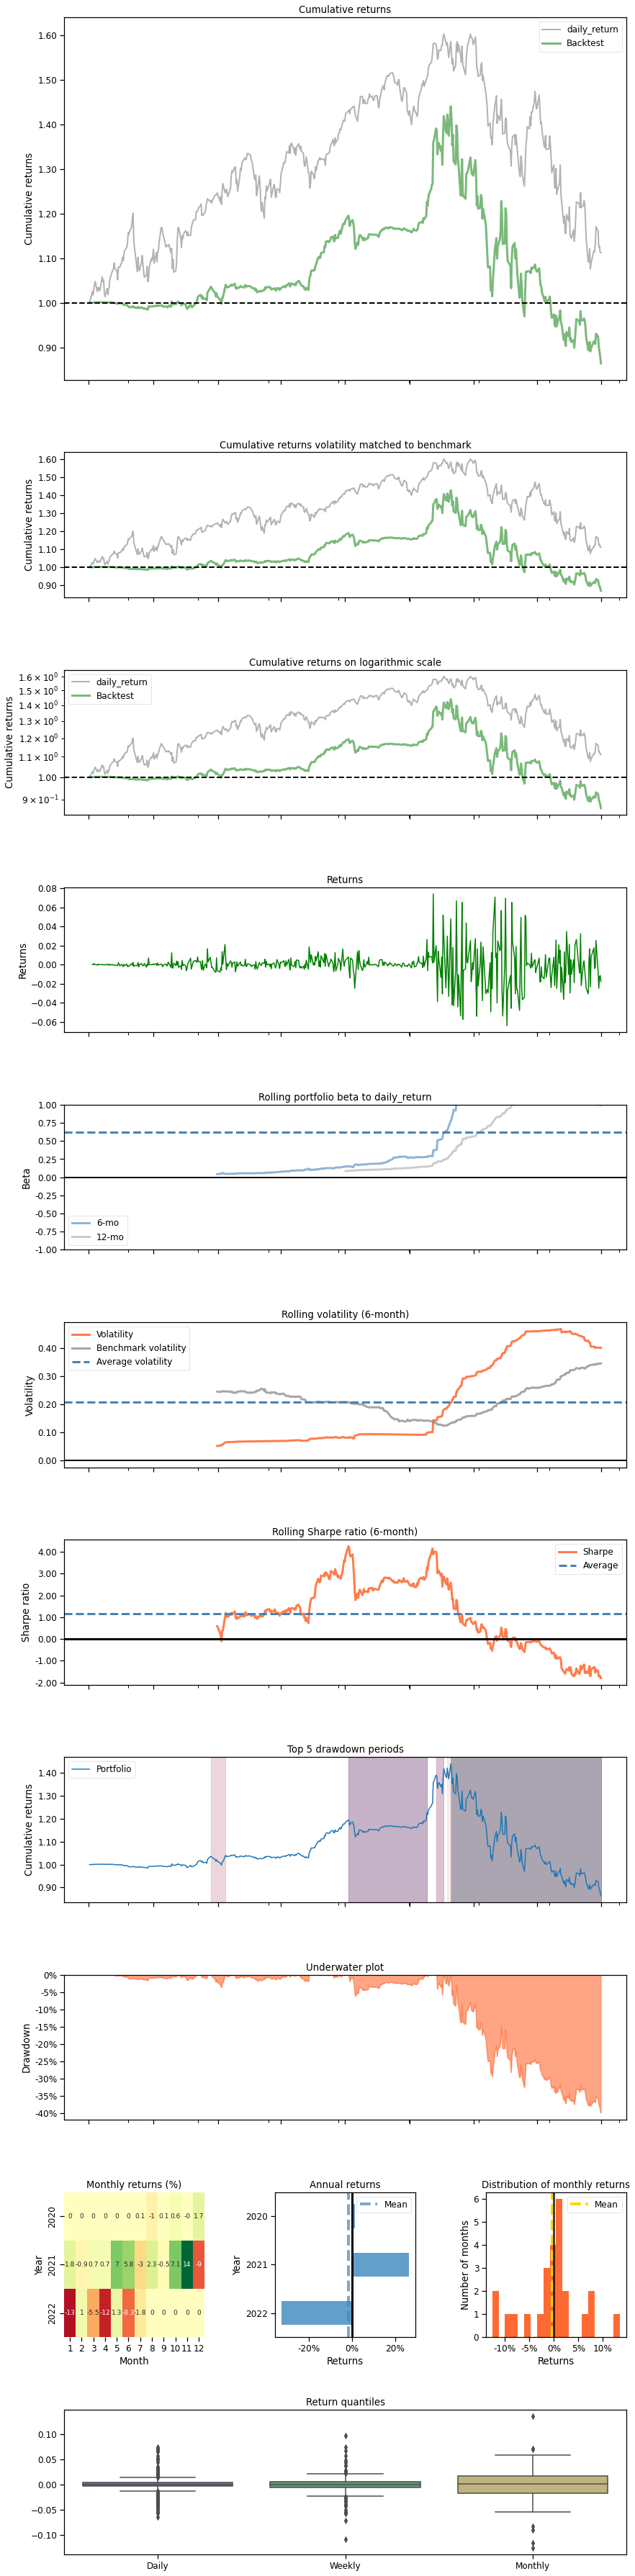

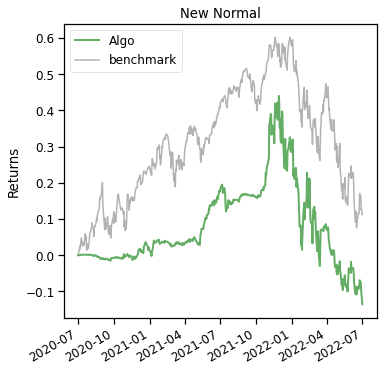

In [34]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = "^NDX", 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'],
             value_col_name="account_value")